How to use Jupyter notebook:
* Use Ctrl+Enter to run a cell.
* Shift+Tab+Tab shows help about current function

Tasks:
* run all the code cell-by-cell with `Ctrl+Enter` or `Shift+Enter`.
* rerun profile generation and plot drawing for several times until plot is beautiful (has two distinct peaks)
* explain what's going on to yourself. What's the principle to split points into peaks/not-peaks (take a look at a figure with colored markers of two types)
* change params so that three peaks are generated
* change params so that there's less noise in a profile
* change window size to calculate features. Which sizes works better
* add two more features with different window sizes (you can use not only mean but also max/min in a window)
* Draw scatterplots with different pairs of features
* Use `predict_proba` method of classifier instead of `predict` to calculate not just labels but probabilities of each position to be inside peak. Plot those probabilities.
* Calculate mean density of peaks for different window sizes. Plot it.


In [1]:
import numpy as np
import scipy.stats
import sklearn
import matplotlib
import matplotlib.pyplot as plt

In [2]:
num_peaks = 2
noise_level = 100
interval_start, interval_end = 0, 100
num_bins = 100

# This function creates a random profile by picking random points from a distribution
# Peaks are sampled from several normal distributions.
# Each such distribution has random center and random wideness (`sigma` aka standard deviation)
# We pick several points (number of points is also random)
def generate_random_peaks():
    # choose random peak centers, wideness and numbers of points.
    centers = np.random.uniform(low=interval_start + 5, high=interval_end - 5, size=(num_peaks))
    sigmas = np.random.choice([2.0, 5.0, 10.0], size=(num_peaks))
    point_counts = np.random.randint(low=35, high=50, size=(num_peaks))
    print(f'Centers: {centers}')
    print(f'Numbers of points around centers: {point_counts}')
    print(f'Standard deviations: {sigmas}')
    print('----------------')
    
    # Pick points from each peak
    points = []
    peak_configs = list(zip(centers, sigmas, point_counts))
    for (center, sigma, num_points) in peak_configs:
        # Here we took centers, sigmas and point counts as columns and read them row-by-row
        # So at each iteration we just take a single peak parameters
        print(f'Generate {num_points} points with center at {center} and sigma {sigma}')
        for i in range(num_points):
            # We should take `num_points` points, so lets take one and repeat
            # here we take a point from normal distribution
            random_number = np.random.normal(loc=center, scale=sigma)
            # round it to an integer and clip (too low and too high values are replaced with just min/max values)
            random_point = np.clip(int(random_number), a_min=interval_start, a_max=interval_end)
            points.append(random_point)

    # Add noise (just random points picked from uniform distribution)
    for i in range(noise_level):
        points.append(np.random.randint(low=interval_start, high=interval_end))
            
    # We treat [center - sigma, center + sigma] as actual peak coordinates
    # All usual points have label 0, peaks have label 1.
    # In more complex programs normally we don't have labels but want to get them
    labels = np.zeros(num_bins,dtype=np.int)
    for (center, sigma, num_points) in zip(centers, sigmas, point_counts):
        for pos in range(max(interval_start, int(center - sigma)), min(interval_end, int(center + sigma) + 1)):
            labels[pos] = 1

    print('----------------')
    print(len(points), 'points generated')
    print('Points:\n', points)
    print(f'Peak positions: {labels}')
    
    # collect points into a histogram
    data, _ = np.histogram(points, bins=num_bins,range=(interval_start,interval_end))
    
    return data, labels, peak_configs

In [22]:
# We calculate mean height (density) of peak in a window [center - size; center + size]
def mean_in_window(xs, center, size):
    left = max(center - size, 0)
    right = min(center + size, len(xs) - 1)
    return np.mean(xs[left:right + 1])

# Calculate features for each position of profile
def calculate_features(data):
    features = []
    for pos in range(0, num_bins):
        # pos iterates over all bins in a profile.
        # for each bin we can calculate a pair of values:
        # means in windows of different wideness
        mean_3 = mean_in_window(data, pos, 3)
        mean_10 = mean_in_window(data, pos, 10)
        # we collect features for all positions into a single array
        features.append((mean_3, mean_10))
    # and then transform an array of arrays into numpy matrix
    features = np.array(features)
    return features

In [18]:
# let's generate one collection of peaks and their features
data, labels, peak_configs = generate_random_peaks()
features = calculate_features(data)

Centers: [91.45476548 42.15525021]
Numbers of points around centers: [37 39]
Standard deviations: [2. 5.]
----------------
Generate 37 points with center at 91.45476547591618 and sigma 2.0
Generate 39 points with center at 42.15525021169006 and sigma 5.0
----------------
176 points generated
Points:
 [92, 95, 87, 88, 91, 92, 91, 91, 89, 90, 88, 91, 93, 89, 94, 91, 91, 89, 92, 92, 88, 91, 90, 87, 95, 94, 93, 94, 91, 90, 90, 89, 95, 96, 91, 90, 92, 32, 40, 37, 48, 54, 44, 36, 36, 39, 40, 49, 43, 39, 47, 43, 50, 39, 48, 38, 37, 39, 42, 36, 39, 29, 47, 41, 46, 35, 39, 36, 42, 44, 43, 50, 47, 43, 35, 44, 1, 67, 62, 3, 92, 25, 43, 96, 32, 77, 60, 41, 59, 17, 75, 78, 80, 47, 96, 40, 32, 82, 96, 15, 68, 13, 32, 77, 47, 72, 85, 39, 76, 99, 14, 82, 10, 88, 22, 50, 37, 65, 23, 17, 68, 77, 31, 7, 72, 11, 38, 29, 75, 25, 5, 32, 70, 23, 72, 23, 31, 85, 78, 22, 13, 29, 58, 85, 28, 33, 82, 83, 62, 68, 69, 22, 18, 78, 88, 49, 97, 43, 48, 89, 25, 54, 96, 36, 14, 3, 80, 71, 53, 53, 39, 36, 36, 71, 42, 95

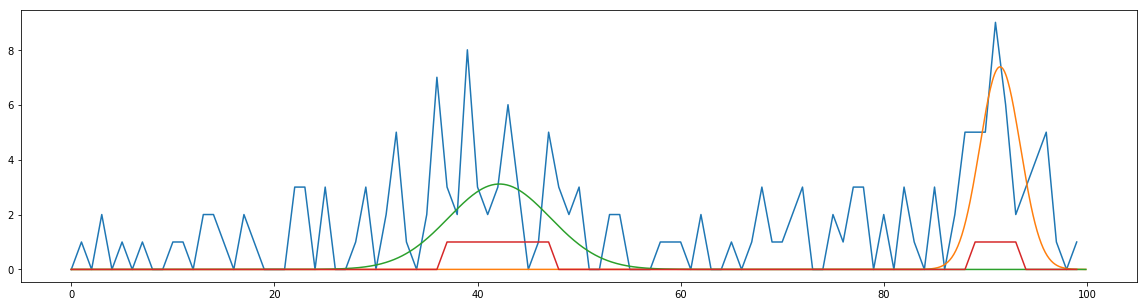

In [19]:
# Lets create a figure with several plots on it
plt.figure(figsize=(20, 5))
# First we draw a profile itself
plt.plot(data)
# Then for each peak we draw a properly scaled normal distribution 
xs = np.arange(interval_start, interval_end, 0.1)
for (center, sigma, num_points) in peak_configs:
    plt.plot(xs, scipy.stats.norm.pdf(xs, center, sigma) * num_points)
# Also we plot which points are labelled as `inside peak` (0 - no peak, 1 - peak)
plt.plot(labels)


In [23]:
print('Peak configs:', peak_configs)
print('Features has size: ', features.shape)

Peak configs: [(91.45476547591618, 2.0, 37), (42.15525021169006, 5.0, 39)]
Features has size:  (100, 2)


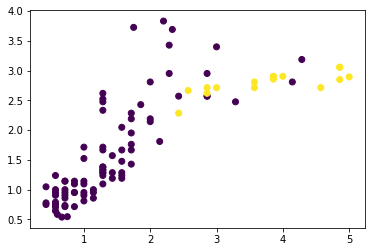

In [24]:
plt.scatter(features[:,0], features[:,1], c=labels)

In [58]:
import sklearn.linear_model
# We'll build a model to classify peaks from non-peaks based on features
# One of the most basic classifiers (an algorithm to split - or classify - data
# into two groups) is a logistic regression
classifier = sklearn.linear_model.LogisticRegression()
# We tune its parameters (train a model) based on our labelled points
# (i.e. points for which we know is it a peak or not)
classifier.fit(features, labels)

# Let's predict points with this model (to understand which points it does or doesn't recognize)
predictions = classifier.predict(features)

# Each error is 0 --> 1 or 1 --> 0.
# Thus an absolute value of difference between value or prediction 
# gives us 1 for error, 0 for correct prediction
# Sum of such values (number of 1-s gives us number of errors)
num_errors = np.sum(np.abs(predictions - labels))
print(f'Real labels: {labels}')
print(f'Predicted labels: {predictions}')
print(f'Num errors: {num_errors}; Accuracy = {round(1 - num_errors/len(labels), 2)}')

Real labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0]
Predicted labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0]
Num errors: 7; Accuracy = 0.93


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


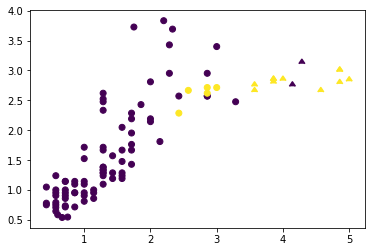

In [59]:
# We plot the same points but now with a marker type we specify points predicted as in-peak or out-of-peak
predicted_indices = (predictions == 1)
antipredicted_indices = (predictions == 0)
plt.scatter(features[predicted_indices,0], features[predicted_indices,1],
            c=labels[predicted_indices],
            marker=matplotlib.markers.CARETUP)
plt.scatter(features[antipredicted_indices,0],
            features[antipredicted_indices,1],
            c=labels[antipredicted_indices])

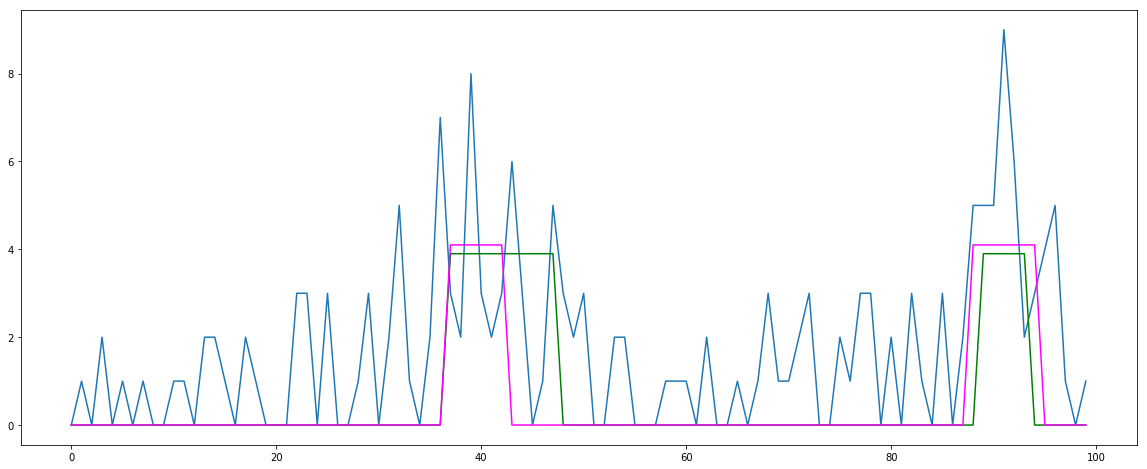

In [31]:
# Now we will plot actual inside-peak points (green) and predicted (magenta)
# They are on a different height just to make differences more visible
plt.figure(figsize=(20, 8))
plt.plot(data)
plt.plot(labels*3.9, color = 'green')
plt.plot(predictions*4.1,color='magenta')

In [27]:
# Let's generate another profile and classify it
data_2, labels_2, peak_configs_2 = generate_random_peaks()
features_2 = calculate_features(data_2)

predictions_2 = classifier.predict(features_2)
num_errors_2 = np.sum(np.abs(predictions_2 - labels_2))
print(f'Real labels: {labels_2}')
print(f'Predicted labels: {predictions_2}')
print(f'Num errors: {num_errors_2}; Accuracy = {round(1 - num_errors_2/len(labels_2), 2)}')

Centers: [92.99226027]
Numbers of points around centers: [45]
Standard deviations: [10.]
----------------
Generate 45 points with center at 92.99226027411018 and sigma 10.0
----------------
145 points generated
Points:
 [100, 100, 80, 82, 97, 100, 78, 96, 87, 100, 97, 87, 77, 82, 100, 68, 83, 95, 94, 100, 99, 100, 78, 94, 98, 100, 100, 83, 73, 80, 100, 100, 84, 71, 100, 89, 90, 100, 93, 97, 100, 80, 86, 96, 100, 86, 31, 3, 11, 74, 82, 69, 85, 80, 72, 52, 38, 7, 42, 18, 38, 41, 72, 13, 5, 1, 72, 58, 16, 61, 88, 55, 39, 16, 78, 21, 84, 10, 85, 11, 60, 98, 68, 19, 60, 19, 98, 69, 57, 92, 18, 49, 50, 54, 24, 67, 3, 68, 2, 59, 93, 97, 99, 29, 19, 40, 55, 62, 25, 86, 46, 92, 79, 36, 44, 63, 41, 12, 44, 83, 47, 15, 85, 30, 20, 30, 61, 36, 85, 84, 11, 83, 92, 75, 28, 60, 71, 69, 95, 40, 54, 98, 8, 42, 72]
Peak positions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 

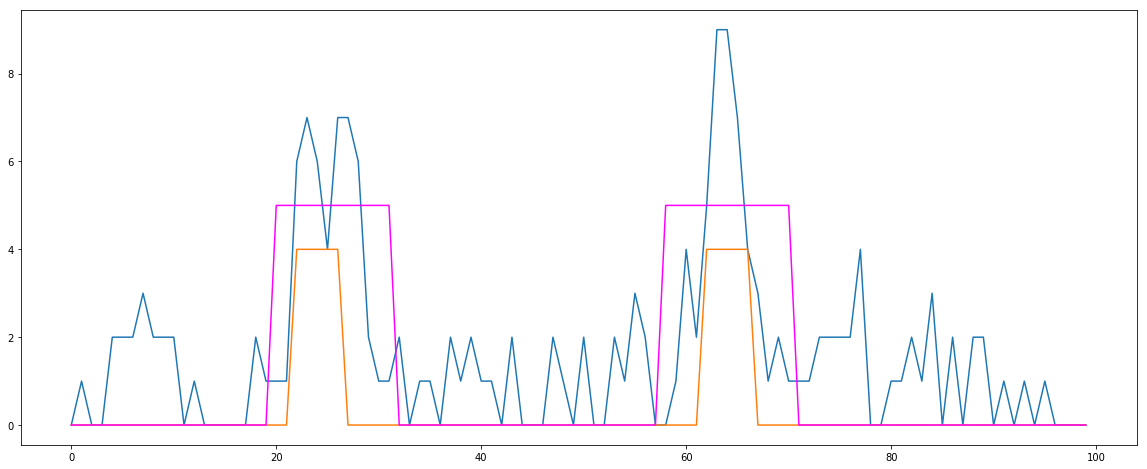

In [16]:
plt.figure(figsize=(20, 8))
plt.plot(data_2)
plt.plot(labels_2*4)
plt.plot(predictions_2*5,color='magenta')